In [1]:
import os

os.makedirs('../out/', exist_ok=True)

STATS_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Stats.parquet',
    'HSC_Lecco_2024': '../data/HSC_Lecco_2024-Players_Daily_Mobility_Stats.parquet',
    'HSC_Ferrara_2023': '../data/HSC_Ferrara_2023-Players_Daily_Mobility_Stats.parquet',
}

SCORES_FILES = {
    'HSC_Lecco_2023': '../data/HSC_Lecco_2023-Players_Daily_Mobility_Scores.parquet',
    'HSC_Lecco_2024': '../data/HSC_Lecco_2024-Players_Daily_Mobility_Scores.parquet',
    'HSC_Ferrara_2023': '../data/HSC_Ferrara_2023-Players_Daily_Mobility_Scores.parquet',
}

In [2]:
import pandas as pd

def load_stats(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df['distance'] = df['distance'] / 1000 # convert to km
    df['campaign'] = c
    df.rename(columns={'modeType': 'counter', 'distance': 'target', 'stat_date': 'ds'}, inplace=True)
    return df[['playerId', 'campaign', 'ds', 'counter', 'target']]

def load_scores(path: str, c: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df.rename(columns={'player_id': 'playerId', 'mobilityScore': 'target', 'day': 'ds'}, inplace=True)
    df['counter'] = 'green leaves'
    df['campaign'] = c
    return df[['playerId', 'campaign', 'ds', 'counter', 'target']]

In [3]:
df_stats = pd.concat([load_stats(f, k) for k, f in STATS_FILES.items()])
df_scores = pd.concat([load_scores(f, k) for k, f in SCORES_FILES.items()])

df = pd.concat([df_stats, df_scores])
df['ds'] = pd.to_datetime(df['ds'])

df = df.groupby(['playerId', 'campaign', 'counter', pd.Grouper(key='ds', freq='W')]).agg(
    score=pd.NamedAgg(column='target', aggfunc='sum'),
    num_trips=pd.NamedAgg(column='target', aggfunc='count'),
).reset_index()

df

,playerId,campaign,counter,ds,score,num_trips
0,u_00144002f1614ee9a45f7822760e3746,HSC_Lecco_2023,green leaves,2023-03-05,15.000000,1
1,u_00144002f1614ee9a45f7822760e3746,HSC_Lecco_2023,walk,2023-03-05,1.206355,1
2,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,bus,2023-03-05,6.484221,1
3,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,bus,2023-04-02,8.404965,2
4,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,green leaves,2023-03-05,47.000000,3
...,...,...,...,...,...,...
18093,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,bus,2024-03-24,32.910082,1
18094,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,green leaves,2024-03-03,100.000000,3
18095,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,green leaves,2024-03-10,108.000000,3
18096,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,green leaves,2024-03-17,182.000000,5


In [4]:
df['week'] = df['ds'].dt.isocalendar().week
df_summary = df.groupby(['counter', 'week', 'campaign']).agg({
    'score': 'median',
    'playerId': 'count',
    'num_trips': 'sum',
}).round(2).reset_index()

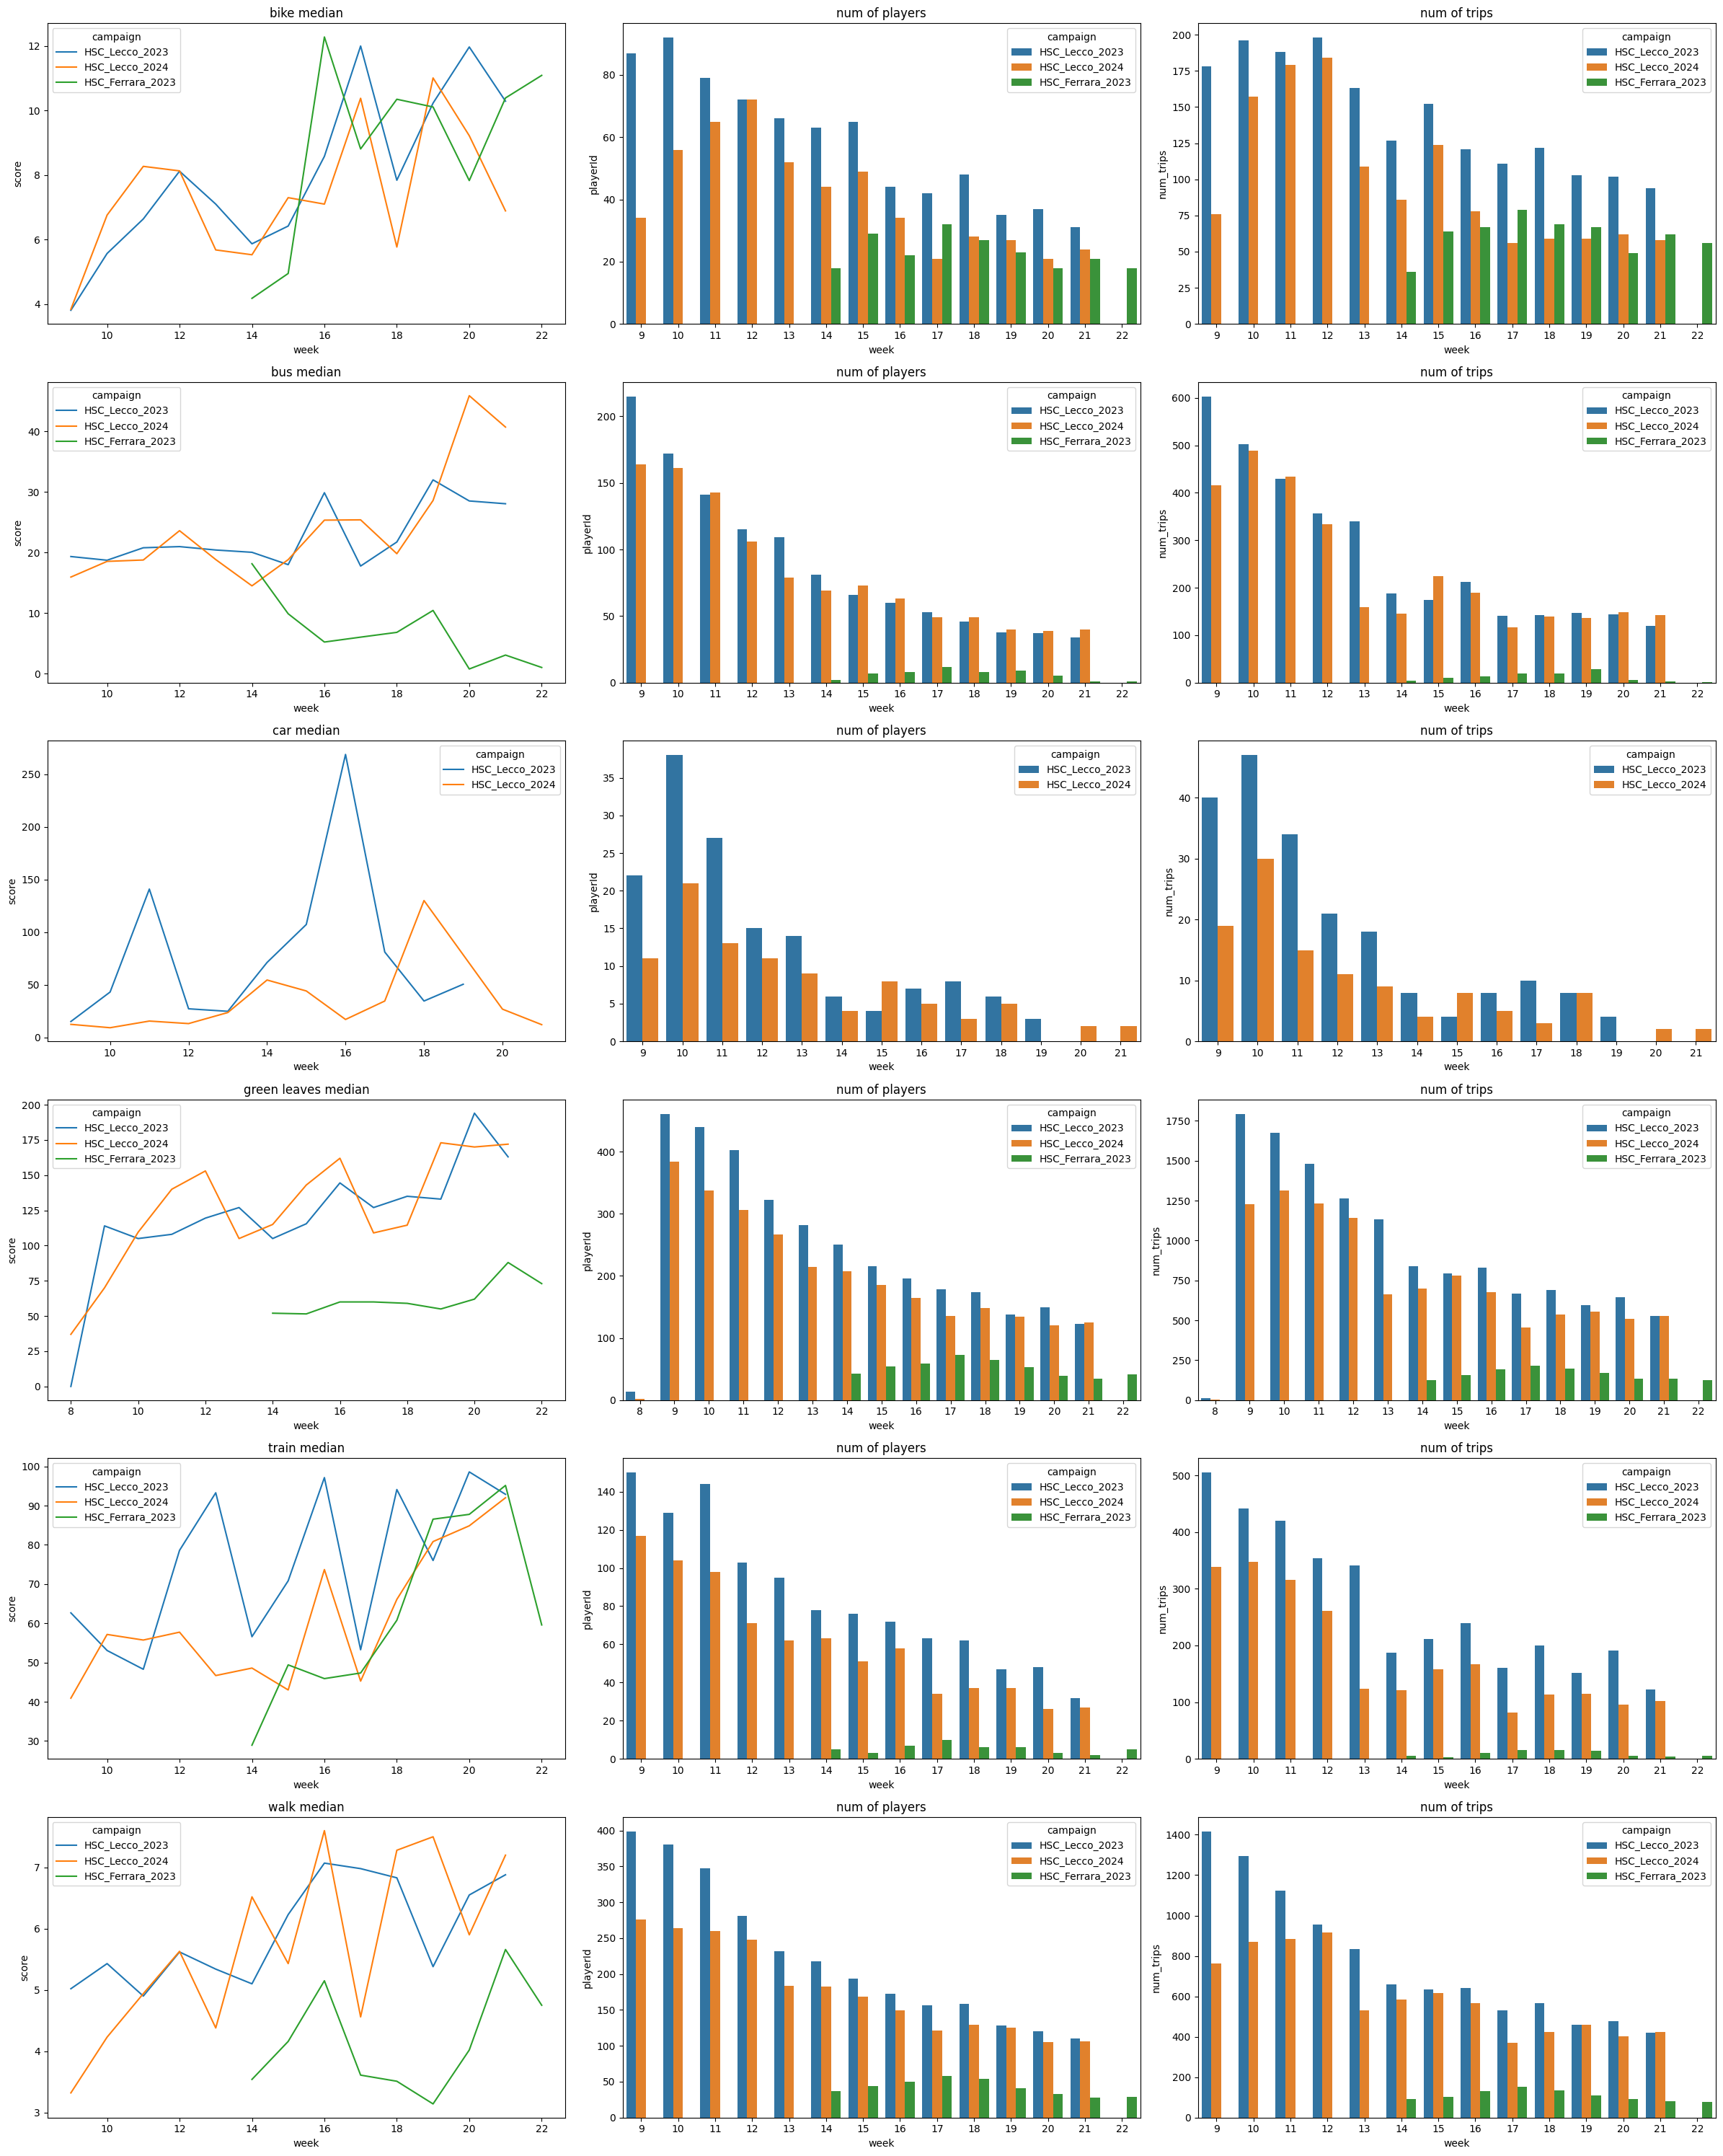

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(
    nrows=df_summary['counter'].nunique(),
    ncols=3,
    figsize=(24, 5 * df_summary['counter'].nunique())
)

for i, counter in enumerate(df_summary['counter'].unique()):
    d = df_summary[df_summary['counter'] == counter]

    sns.lineplot(data=d, x='week', y='score', hue='campaign', ax=axs[i, 0])
    axs[i, 0].set_title(f'{counter} median')

    sns.barplot(data=d, x='week', y='playerId', hue='campaign', ax=axs[i, 1])
    axs[i, 1].set_title(f'num of players')

    sns.barplot(data=d, x='week', y='num_trips', hue='campaign', ax=axs[i, 2])
    axs[i, 2].set_title(f'num of trips')
    
plt.tight_layout()
plt.savefig('../out/players_mobility_stats.pdf')

In [6]:
df = df.pivot(index=['playerId', 'campaign', 'ds'], columns='counter', values='score').fillna(0).reset_index()

df

counter,playerId,campaign,ds,bike,bus,car,green leaves,train,walk
0,u_00144002f1614ee9a45f7822760e3746,HSC_Lecco_2023,2023-03-05,0.0,0.000000,0.0,15.0,0.000000,1.206355
1,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,2023-03-05,0.0,6.484221,0.0,47.0,0.000000,1.983675
2,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,2023-03-12,0.0,0.000000,0.0,108.0,0.000000,8.643765
3,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,2023-03-19,0.0,0.000000,0.0,65.0,45.453794,1.527971
4,u_00567a7bce8c4d09bea7db9bae375af4,HSC_Lecco_2023,2023-03-26,0.0,0.000000,0.0,27.0,0.000000,1.839047
...,...,...,...,...,...,...,...,...,...
6545,u_ffe87d71a9ee4521bddf686053b7f8b7,HSC_Lecco_2023,2023-05-28,0.0,0.000000,0.0,126.0,0.000000,2.693552
6546,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,2024-03-03,0.0,52.580290,0.0,100.0,0.000000,0.000000
6547,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,2024-03-10,0.0,66.544132,0.0,108.0,0.000000,0.000000
6548,u_ffff190ed0ba42759b2f201c5e11ae0c,HSC_Lecco_2024,2024-03-17,0.0,115.080471,0.0,182.0,0.000000,0.000000


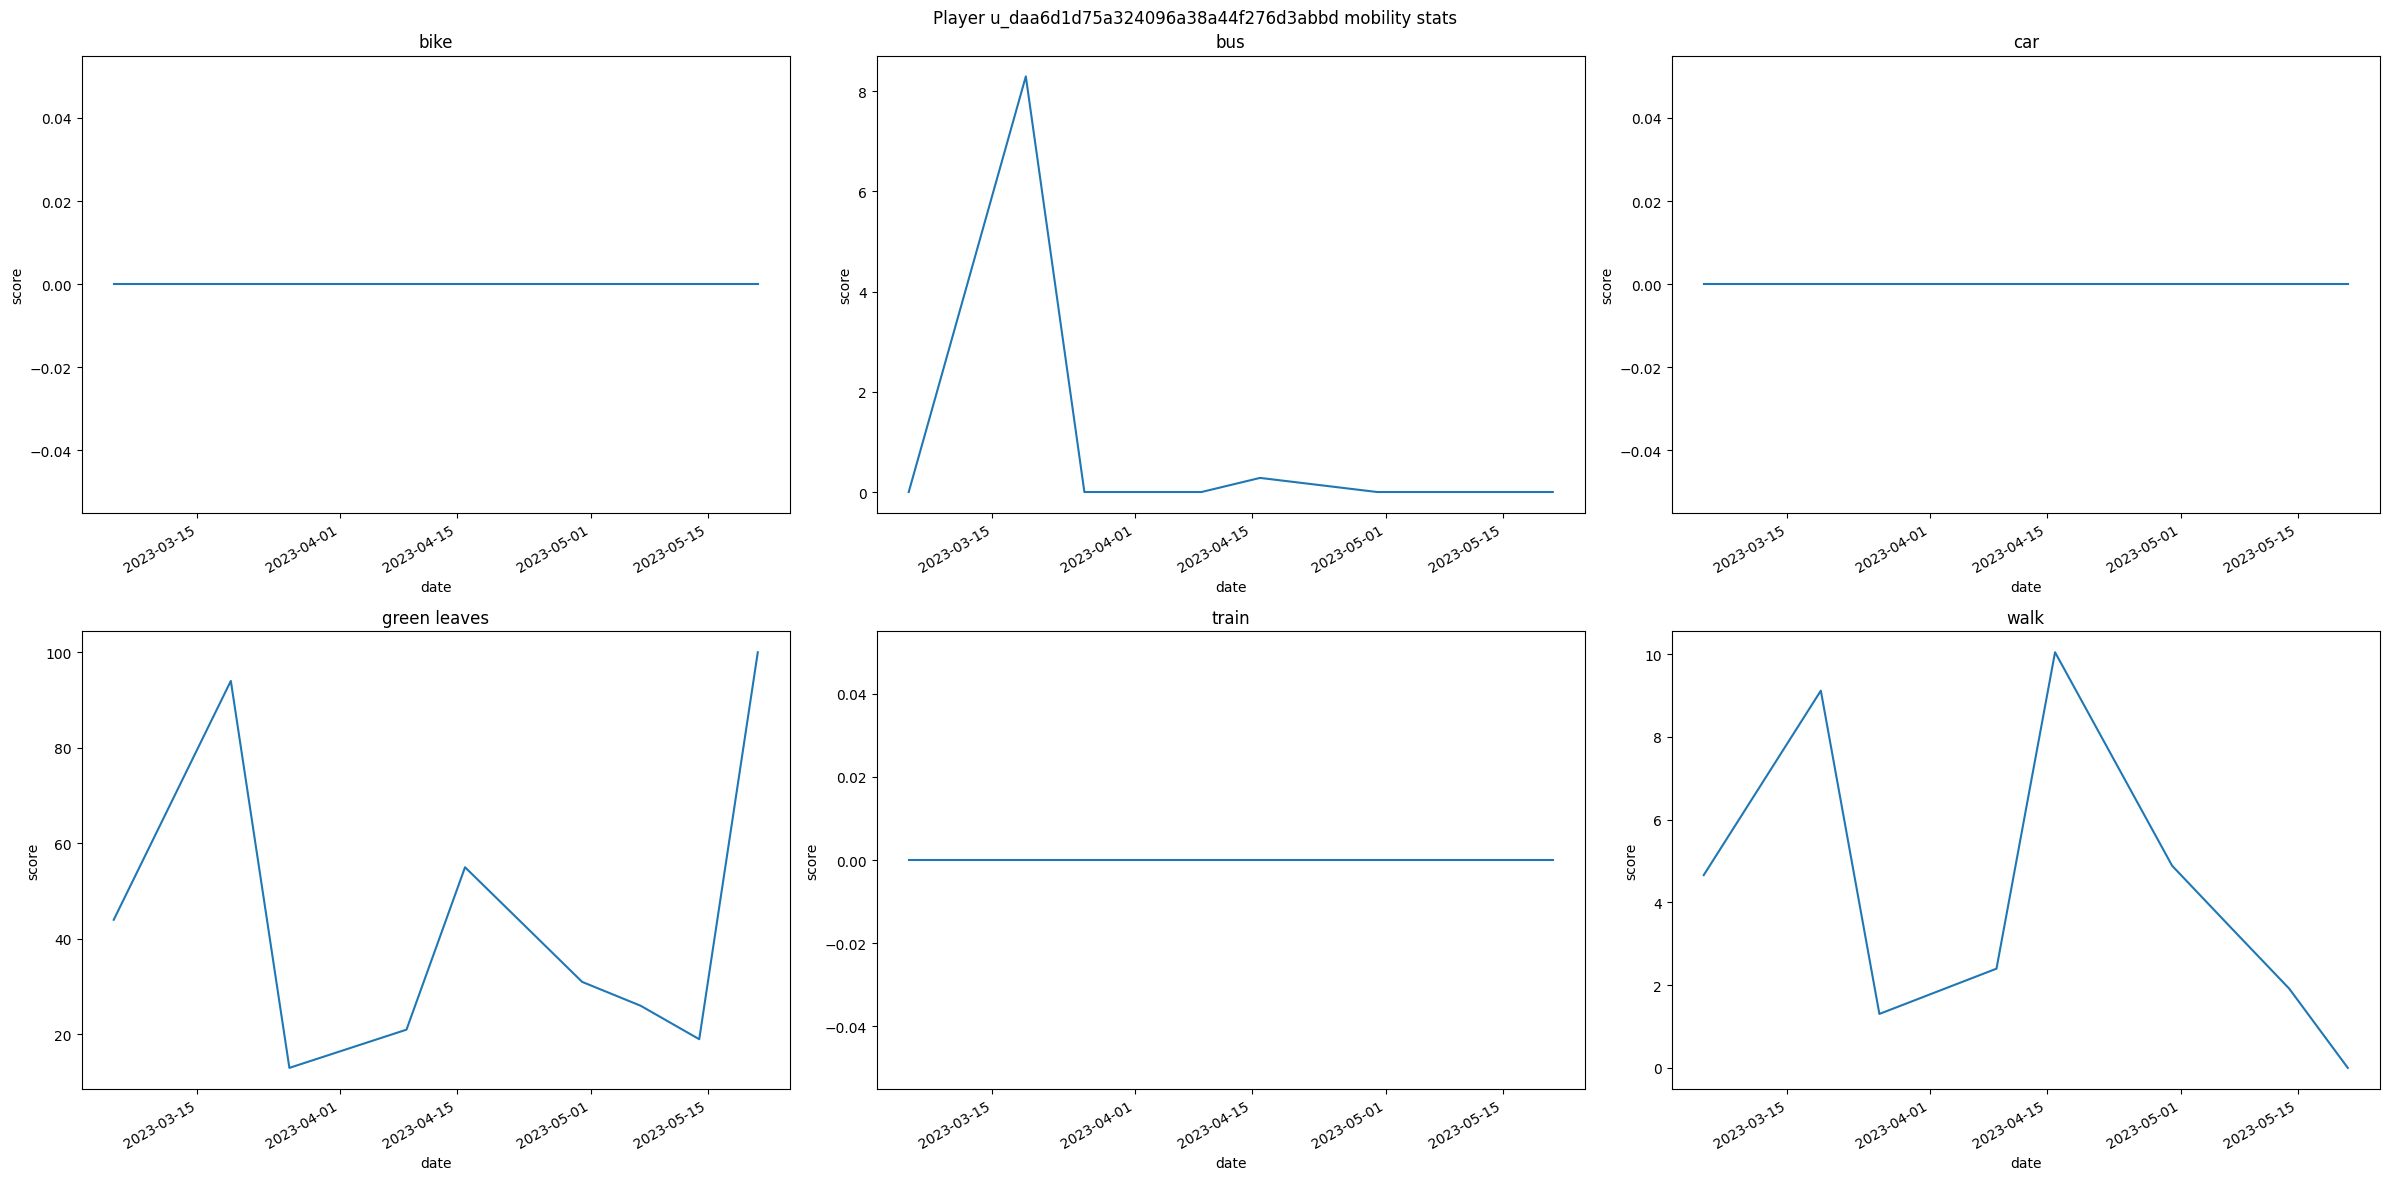

In [20]:
import numpy as np

def plot_player_mobility(df: pd.DataFrame, player_id: int):
    fig, axs = plt.subplots(2, 3, figsize=(24, 12))
    d = df[df['playerId'] == player_id].copy()
    d.set_index('ds', inplace=True)
    d.drop(columns=['playerId', 'campaign'], inplace=True)

    for ax, counter in zip(axs.flatten(), d.columns):
        d[counter].plot(ax=ax)
        ax.set_title(counter)
        ax.set_ylabel('score')
        ax.set_xlabel('date')
    
    fig.suptitle(f'Player {player_id} mobility stats')
    fig.tight_layout()

user = np.random.choice(df['playerId'].unique())

plot_player_mobility(df, user)

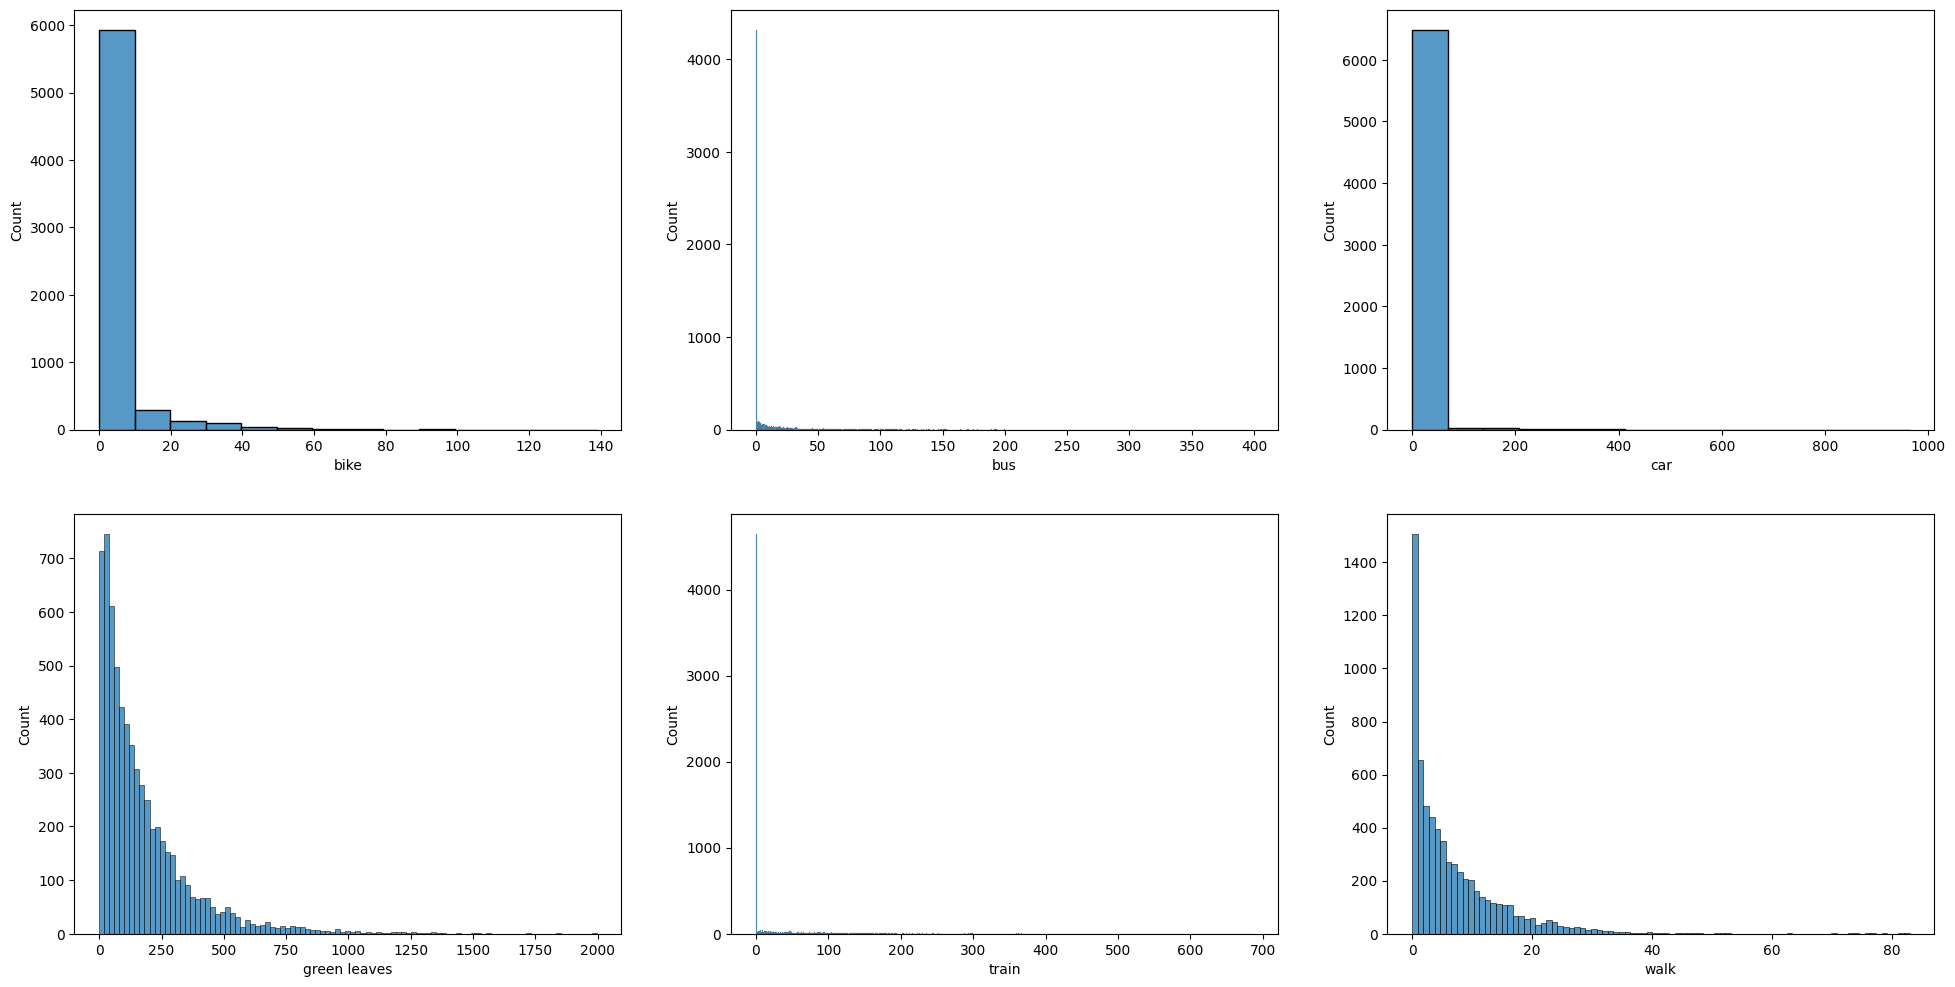

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(24, 12))

d = df.drop(columns=['playerId', 'campaign', 'ds'])

for ax, counter in zip(axs.flatten(), d.columns):
    sns.histplot(d[counter], ax=ax, kde=False)